In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
def sghmc_scalar(U, gradU, m, dt, nstep, x, C, V):
    p = np.random.randn() * np.sqrt(m)
    B = 0.5 * dt * V
    D = np.sqrt(2. * (C-B) * dt)
    for i in range(nstep):
        p += -gradU(x) * dt - p * C * (1./m) * dt + np.random.randn() * D
        x += p/m * dt
    return x

In [3]:
def hmc_scalar(U, gradU, m, dt, nstep, x):
    p = np.random.randn() * np.sqrt(m)
    oldX = x
    oldEnergy = p * (1./m) * p / 2 + U(x)
    for i in range(nstep):
        p -= gradU(x) * dt/2.
        x += p/m * dt
        p -= gradU(x) * dt/2.
    newEnergy = p * (1./m) * p / 2 + U(x)
    if np.random.random() > np.exp(oldEnergy - newEnergy): # Metropolis-Hastings
        x = oldX
    return x

In [4]:
def U(x):
    return -2. * x**2 + x**4

def gradU_scalar(x):
    return -4. * x + 4. * x**3 + np.random.randn() * 2.

def gradU_perfect(x):
    return -4. * x + 4. * x**3

In [5]:
nsample = 80000
xStep = 0.1
m = 1.
C = 3.
dt = 0.1
nstep = 50
V = 4.

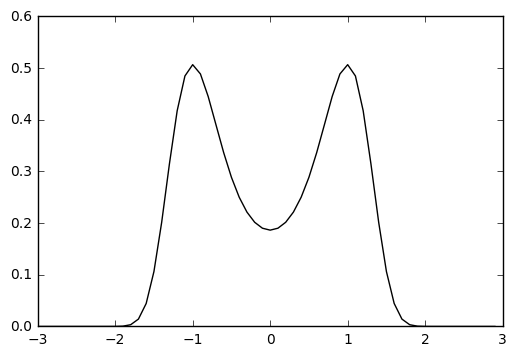

In [6]:
xGrid = np.arange(-3., 3., xStep)
y = np.exp( - U(xGrid) )
y = y / (np.sum(y) * xStep)
plt.plot(xGrid,y, '-k')

# Stochastic HMC

In [7]:
samples = np.zeros(nsample)
x = 0.
for i in range(nsample):
    x = sghmc_scalar( U, gradU_scalar, m, dt, nstep, x, C, V )
    samples[i] = x

In [8]:
yshmc = scipy.stats.histogram(samples, numbins=len(xGrid), defaultlimits=(-3.,3.))[0]
yshmc = yshmc / (np.sum(yshmc) * xStep)

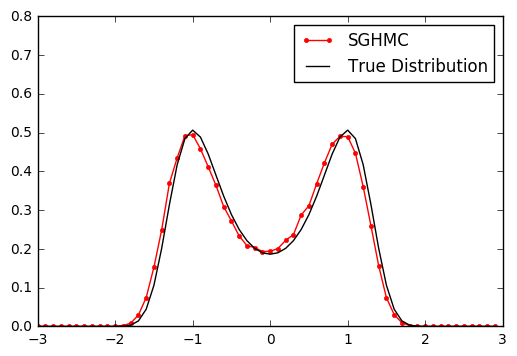

In [9]:
plt.plot(xGrid,yshmc, '.-r', label='SGHMC')
plt.plot(xGrid,y, '-k', label='True Distribution')
plt.ylim(0.0,0.8)
plt.legend()

# HMC

In [10]:
samples = np.zeros(nsample)
x = 0.
for i in range(nsample):
    x = hmc_scalar( U, gradU_scalar, m, dt, nstep, x )
    samples[i] = x

In [11]:
yhmc = scipy.stats.histogram(samples, numbins=len(xGrid), defaultlimits=(-3.,3.))[0]
yhmc = yhmc / (np.sum(yhmc) * xStep)

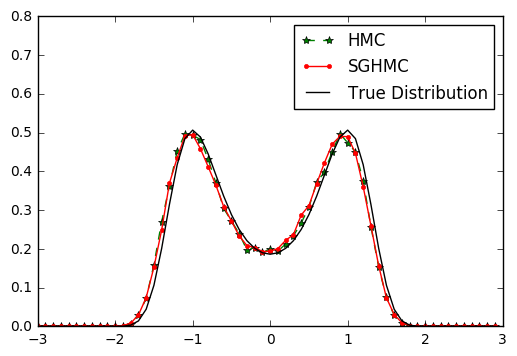

In [12]:
plt.plot(xGrid,yhmc, '*--g', label='HMC')
plt.plot(xGrid,yshmc, '.-r', label='SGHMC')
plt.plot(xGrid,y, '-k', label='True Distribution')
plt.ylim(0.0,0.8)
plt.legend()

# Multidimensional SGHMC

In [13]:
def sghmc_vectorNew(gradU, eta, L, alpha, x, V):
    beta = 0.5 * V * eta
    p = np.random.randn(len(x)) * np.sqrt( eta )
    momentum = 1. - alpha
    try:
        sigma = np.sqrt( 2. * eta * (alpha-beta) )
    except:
        print('eta too big')
    for i in range(L):
        p = p * momentum - gradU( x ) * eta + np.random.randn(len(p)) * sigma
        x += p
    return x.copy()

In [14]:
def U(x):
    sigma = np.array([[1.,0.9],[0.9,1.]])
    return 0.5 * x.dot( np.linalg.solve(sigma,x))

def gradU_vector(x):
    mean = np.zeros_like(x)
    sigma = np.array([[1.,0.9],[0.9,1.]])
    return np.linalg.solve(sigma,x) + np.random.randn(len(x))

In [15]:
xGrid = np.linspace(-2., 3., 200)
yGrid = np.linspace(-2., 3., 200)

XGrid, YGrid = np.meshgrid(xGrid, yGrid)

Z = np.zeros((xGrid.shape[0], yGrid.shape[0]))
for i in range(xGrid.shape[0]):
    for j in range(yGrid.shape[0]):
        Z[i,j] = np.exp(-U(np.array([xGrid[i],yGrid[j]])))

In [16]:
nsample = 8000
V = 1
etaSGHMC = 0.05
alpha = 0.035
L = 50

In [17]:
samples = []
x = np.array([0.,0.])
for i in range(nsample):
    x = sghmc_vectorNew( gradU_vector, etaSGHMC, L, alpha, x, V )
    samples.append(x.copy())

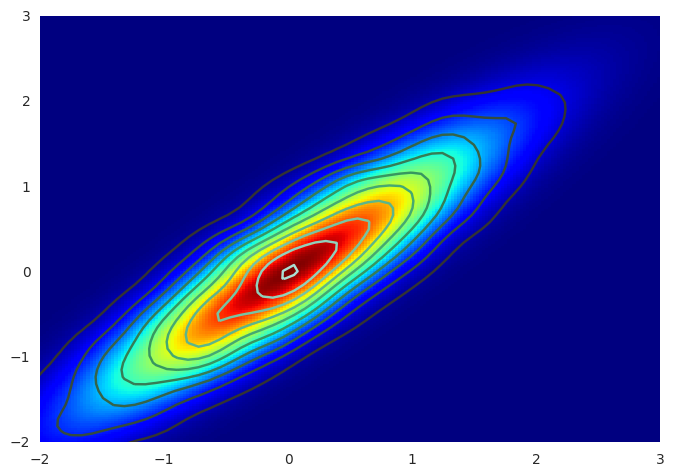

In [18]:
import seaborn as sns

samples = np.array(samples)

plt.pcolor(XGrid, YGrid, Z, cmap='jet')
sns.kdeplot(samples[:,0],samples[:,1])
plt.xlim(-2,3)
plt.ylim(-2,3)
pass